# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn seaborn pandas

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/65/58/f9c9e6be752e9fcb8b6a0ee9fb87e6e7a1f6bcab2cdc73f02bb7ba91ada0/tzdata-2024.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.0 MB/s eta 0:00:001.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.6.2
charset-normalizer           3.3.2
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.53.0
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       1.64.1
h5py                         3.11.0
idna                         3.7
ipykernel                    6.29.4
ipython                      8.25.0
jedi                         0.19.1
joblib                       1.4.2
jupyter_client               8.6.2
jupyter_core                 5.7.2
keras                        3.3.3
kiwisolver                   1.4.5
li

In [3]:
import tensorflow as tf
import os

2024-06-04 19:14:20.037860: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 19:14:20.038241: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 19:14:20.042118: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 19:14:20.088875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 19:14:20.875488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [4]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [6]:
import cv2
import imghdr

/tmp/ipykernel_16160/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 1208 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [13]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

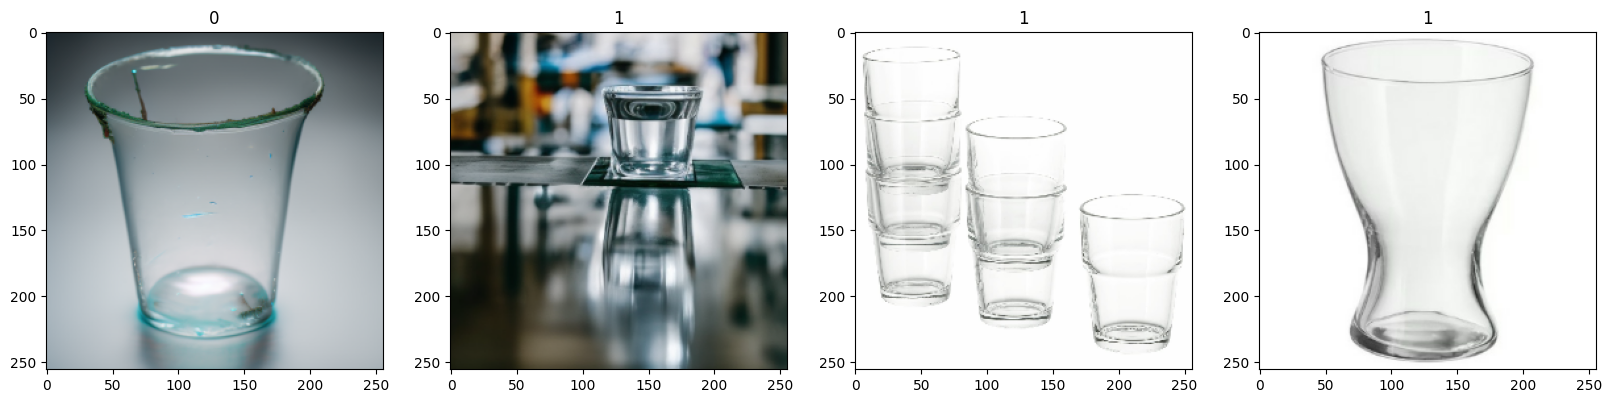

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [15]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

(array([[[[0.8745098 , 0.86470586, 0.8480392 ],
          [0.86764705, 0.8568627 , 0.84411764],
          [0.8666667 , 0.8568627 , 0.84607846],
          ...,
          [0.87058824, 0.845098  , 0.8333333 ],
          [0.8715686 , 0.84705883, 0.83235294],
          [0.86960787, 0.84313726, 0.8372549 ]],
 
         [[0.872549  , 0.8617647 , 0.8480392 ],
          [0.87058824, 0.8617647 , 0.8480392 ],
          [0.8666667 , 0.85784316, 0.84607846],
          ...,
          [0.8745098 , 0.84705883, 0.83431375],
          [0.87058824, 0.84607846, 0.83137256],
          [0.872549  , 0.8480392 , 0.83431375]],
 
         [[0.87058824, 0.8607843 , 0.8480392 ],
          [0.8686274 , 0.8598039 , 0.84705883],
          [0.86960787, 0.8598039 , 0.84705883],
          ...,
          [0.86960787, 0.845098  , 0.8303922 ],
          [0.87058824, 0.84607846, 0.8333333 ],
          [0.86960787, 0.84411764, 0.83137256]],
 
         ...,
 
         [[0.8980392 , 0.8960784 , 0.87941176],
          [0.89607

In [16]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [17]:
train_size

26

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/karol/Developments/Image-Classification/imageclassification/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Trenowanie

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.5807 - loss: 0.9999 - val_accuracy: 0.8477 - val_loss: 0.4059
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.8248 - loss: 0.4198 - val_accuracy: 0.8672 - val_loss: 0.3129
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.8643 - loss: 0.3274 - val_accuracy: 0.8711 - val_loss: 0.2806
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.9176 - loss: 0.2203 - val_accuracy: 0.9102 - val_loss: 0.2485
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9259 - loss: 0.1928 - val_accuracy: 0.8945 - val_loss: 0.2725
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.9343 - loss: 0.2083 - val_accuracy: 0.9180 - val_loss: 0.2403
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.9548 - loss: 0.1222 - val_accuracy: 0.9375 - val_loss: 0.1862
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9811 - loss: 0.0797 - val_accuracy: 0.

# 7. Badanie wydajności, wykaz strat

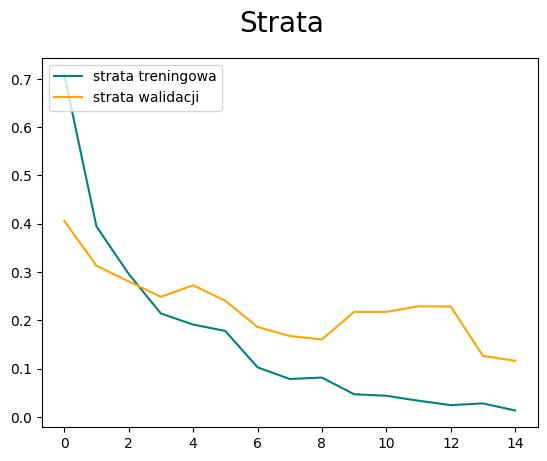

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

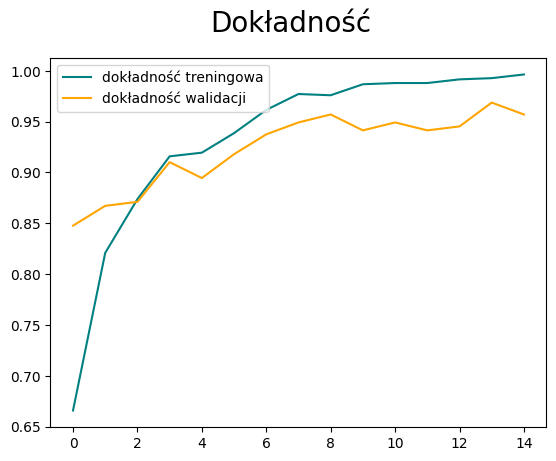

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Test

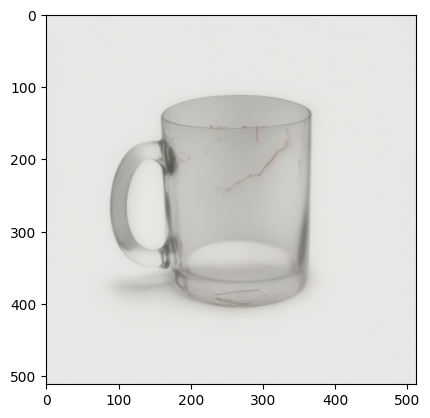

In [29]:
img = cv2.imread('testing/failure_10.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

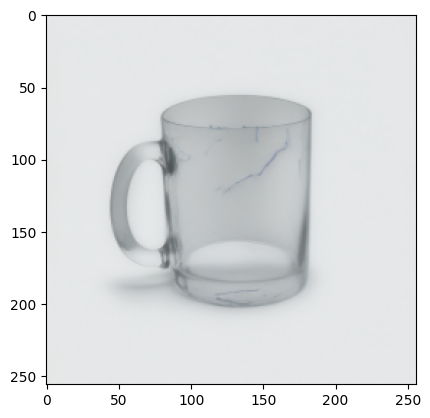

In [30]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [32]:
yhat

array([[0.0184119]], dtype=float32)

In [33]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część uszkodzona


# 10. Zapis modelu

In [34]:
from tensorflow.keras.models import load_model

In [35]:
model.save(os.path.join('models', 'imageclassicationversionlive.keras'))

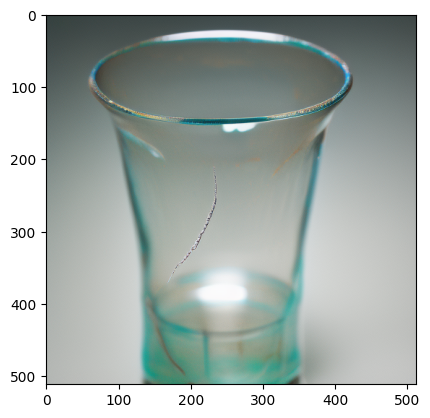

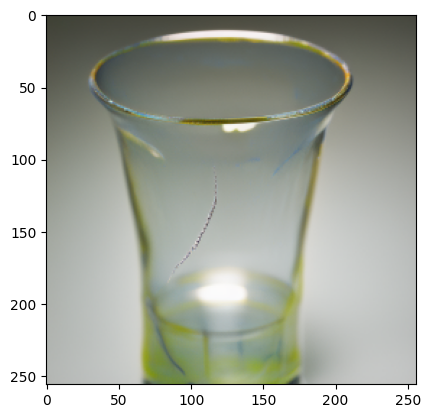

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Wskazany obraz został sklasyfikowany jako część uszkodzona


In [36]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.keras'))

img = cv2.imread('testing/failure_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

# 11. Ocena modelu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
{'uszkodzony': {'precision': 0.9705882352941176, 'recall': 0.9565217391304348, 'f1-score': 0.9635036496350365, 'support': 69.0}, 'prawidłowy': {'precision': 0.9423076923076923, 'recall': 0.9607843137254902, 'f1-score': 0.9514563106796117, 'support': 51.0}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9564479638009049, 'recall': 0.9586530264279625, 'f1-score': 0.9574799801573242, 'support': 120.0}, 'weighted avg': {'precision': 0.9585690045248868, 'recall': 0.9583333333333334, 'f1-score': 0.958383530578981, 'support': 120.0}}


2024-06-04 19:16:32.397283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


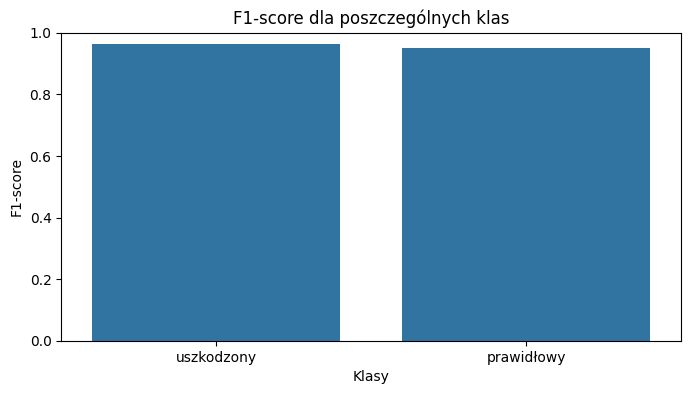

In [37]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.keras'))
from sklearn.metrics import classification_report

# Ewaluacja modelu na zbiorze testowym
y_test = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)
    predictions = np.round(predictions).reshape(-1)
    y_test.extend(labels.numpy())
    y_pred.extend(predictions)

# Obliczenie precyzji, czułości (recall) i F1-score
report = classification_report(y_test, y_pred, target_names=['uszkodzony', 'prawidłowy'], output_dict=True)
print(report)

# Wizualizacja raportu klasyfikacji
import seaborn as sns
import pandas as pd

report_df = pd.DataFrame(report).transpose()
report_df = report_df[:-3]  # Usunięcie zbędnych wierszy (accuracy, macro avg, weighted avg)

plt.figure(figsize=(8, 4))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.ylim(0, 1)
plt.title('F1-score dla poszczególnych klas')
plt.xlabel('Klasy')
plt.ylabel('F1-score')
plt.show()